In [1]:
import email
import pandas as pd
from fast_mail_parser import parse_email, ParseError
import numpy as np
import re
import os
import langdetect as ld
from bs4 import BeautifulSoup

In [2]:
pd.set_option('display.max_colwidth',50)

In [3]:
def strip_tags(html):
    s = BeautifulSoup(html,'html.parser')
    return s.get_text()

def get_lang(text: str) -> str:
    try:
        if text.strip() == '':
            return "empty"
        else:
            return ld.detect(text)
    except:
        return "unknown"
    
def remove_punct(text: str) -> str:
    txt = re.sub('[^a-zA-Z]', ' ', text)
    return txt

In [4]:
trainPish = pd.DataFrame()
encodingErrorFiles = list()
bodyData = pd.DataFrame(columns=['Text','Index','Body html'])
idx2 = 0

for filename in os.listdir("C:\\Users\\Dan\\Downloads\\phishing_pot-main\\email"):
    with open(os.path.join("C:\\Users\\Dan\\Downloads\\phishing_pot-main\\email",filename), "r",encoding="utf8") as f:
        #print(filename)
        try:
            message_payload = f.read()
            try:
                email = parse_email(message_payload)  #Is a dict
            except ParseError as e:
                print("Failed to parse the email ", e)
            
            listKeys = ["From", "Subject", "To", "Return-Path", "Authentication-Results", "Message-Id"]
            
            #In case the "To" header is written wrong(less than 10 files in the dataset are)
            try:
                email.headers["To"]
            except KeyError:
                for k in email.headers.keys():
                    if "to" in k.lower():
                        listKeys.append(k)
                        listKeys.remove("To")
                        break
            
            #Transform from list to array to match the required shape (1,5) to (1,5)
            #Case insensitive dictionary
            H_lower = {k.lower():v for k,v in email.headers.items()}
            
            #Initialize values not found in the email body to make sure no errors are present
            for k in listKeys:
                try:
                    H_lower[k.lower()]
                except KeyError:
                    H_lower[k.lower()] = "None"
                    
            data = [H_lower[k.lower()] for k in listKeys]
            data2 = np.array([data])
            index = H_lower["message-id"]
            index2 = index
            if index2 == "None":
                index2 = "I" + str(idx2)
                idx2 += 1
            pData = pd.DataFrame(data=data2, columns=listKeys)
            pData.set_index('Message-Id', inplace=True)
                
            emailDic = {
                "Index": index2,
                "DKIM": -1,  #Checks whether the email passed the dkim check
                "SPF": -1,  #Checks whether the email passed the spf check
                "DMARC": -1,  #Checks whether the email passed the dmarc check
                "ARC": -1,  #Checks whether the email passed the arc check
                "Body dear word": -1,  #Checks whether the email has the "dear" word inside it
                "Body form": -1,  #Checks whether the email has a form html tag 
                "Body html": -1,  #Checks whether the email contains html
                "Body button": -1,  #Checks whether the email has buttons
                "Number of Links": 0,  #Counts the number of links inside the email
                "Body Verify your account": -1,  #Checks whether the email contains the string "verify your account"
                "Body no of function words": 0,  #Counts the number of function words
                "From eq Return": -1  #Checks whether the from address is equal to the reply address
            }
            
            functionWords = ["Account", "Access", "Bank", "Credit", "Click", "Identity", "Inconvenience", "Information", "Limited",
                             "Log", "Minutes", "Password", "Recently", "Risk", "Security", "Social", "Service", "Suspended",
                             "Urgent"]
            
            #Get email html/text 
            try:
                contentType = H_lower["Content-type".lower()]
            except KeyError:
                contentType = "text/plain"
            
            body = ''
            if "text/html" in contentType:
                body = email.text_html[0]
                df = {"Text": body,'Index':index2, 'Body html': 1}
                df = pd.Series(df)
                bodyData = bodyData._append(df,ignore_index=True)
                emailDic["Body html"] = 1
            elif "text/plain" in contentType:
                body = email.text_plain[0]
                df = {"Text": body,'Index':index2, 'Body html': 0}
                df = pd.Series(df)
                bodyData = bodyData._append(df,ignore_index=True)
                emailDic["Body html"] = 0
            elif "multipart/alternative" or " multipart/mixed" in contentType:
                try:
                    body = email.text_plain[0]
                    df = {"Text": body,'Index':index2,'Body html': 0}
                    emailDic["Body html"] = 0
                except:
                    try: 
                        body = email.text_html[0]
                        df = {"Text": body,'Index':index2,'Body html': 1}
                        emailDic["Body html"] = 1
                    except:
                        emailDic["Body html"] = 0
                        df = {"Text": body,'Index':index2,'Body html': 0}
                        pass
                df = pd.Series(df)
                bodyData = bodyData._append(df,ignore_index=True)
            else:
                emailDic["Body html"] = 0
                df = {"Text": body,'Index':index,'Body html': 0}
                df = pd.Series(df)
                bodyData = bodyData._append(df,ignore_index=True)
            #print(body)
            
            #Verify Dkim, spf, arc and dmarc passes
            if "dkim=pass" in pData.loc[index]["Authentication-Results"]:
                emailDic["DKIM"] = 1
            else:
                emailDic["DKIM"] = 0
            if "spf=pass" in pData.loc[index]["Authentication-Results"]:
                emailDic["SPF"] = 1
            else:
                emailDic["SPF"] = 0
            if "dmarc=pass" in pData.loc[index]["Authentication-Results"]:
                emailDic["DMARC"] = 1
            else:
                emailDic["DMARC"] = 0
            if "arc=pass" in pData.loc[index]["Authentication-Results"]:
                emailDic["ARC"] = 1
            else:
                emailDic["ARC"] = 0
            
            
            def containsWrapper(searchValue: str, text: str) -> int:
                return 1 if searchValue in text else 0
            
            
            dear, form, button, verifyAcc = containsWrapper("dear", body.lower()), containsWrapper("<form", body), containsWrapper(
                "<button", body), containsWrapper("Verify your account", body.lower())
            myValues = [dear, form, button, verifyAcc]
            myKeys = ["Body form", "Body dear word", "Body button", "Body Verify your account"]
            
            for x, y in zip(myKeys, myValues):
                emailDic[x] = y
            
            #Verify if "from" addr eq to "return" addr
            try:
                fromAddress = re.search('<(.*?)>', str(pData.iloc[0]["From"])).group(1)
            except AttributeError as e:
                fromAddress = str(pData.iloc[0]["From"])
            if fromAddress == pData.iloc[0]["Return-Path"]:
                emailDic["From eq Return"] = 1
            else:
                emailDic["From eq Return"] = 0
            
            #Count the number of links by counting the number of href tags in html code
            links = re.findall(r'<a\s+[^>]*href=["\']?(http[^\'" >]+)', body.lower(), re.M)
            emailDic["Number of Links"] = len(links)
            
            #Count the number of function words inside the email
            for word in functionWords:
                if body.lower().find(word.lower()) != -1:
                    emailDic["Body no of function words"] += 1
            
            #Print the data for the model
            trainPish = pd.concat([trainPish, pd.DataFrame(data=[emailDic])])
            
        except UnicodeDecodeError:
            encodingErrorFiles.append(filename)

In [5]:
#Print files with encoding errors
print(encodingErrorFiles) 

['sample-1095.eml', 'sample-117.eml', 'sample-123.eml', 'sample-1233.eml', 'sample-131.eml', 'sample-1315.eml', 'sample-133.eml', 'sample-1420.eml', 'sample-1525.eml', 'sample-1635.eml', 'sample-166.eml', 'sample-1919.eml', 'sample-1955.eml', 'sample-1975.eml', 'sample-1995.eml', 'sample-20.eml', 'sample-2148.eml', 'sample-2451.eml', 'sample-263.eml', 'sample-3192.eml', 'sample-3268.eml', 'sample-354.eml', 'sample-391.eml', 'sample-392.eml', 'sample-428.eml', 'sample-429.eml', 'sample-430.eml', 'sample-432.eml', 'sample-433.eml', 'sample-822.eml', 'sample-894.eml', 'sample-990.eml']


In [6]:
trainPish.set_index(["Index"], inplace=True)
bodyData.set_index(["Index"], inplace=True)

#Apply the stripping for the emails where I have just the html information
bodyData['Text'] = bodyData.apply(lambda row: strip_tags(row["Text"]) if row["Body html"] == 1 else row["Text"],axis=1)

<Axes: xlabel='Lang'>

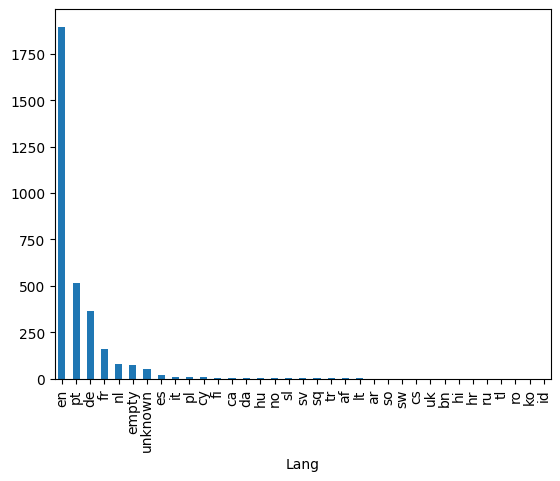

In [7]:
bodyData['Lang'] = bodyData['Text'].apply(get_lang)
bodyData['Lang'].value_counts().plot(kind='bar')

In [268]:
#print(bodyData.query("Lang == 'empty'").value_counts())
print(bodyData.loc["<CANXpgOo_98j4Gfuj2mMFYUaTgWQhW4GxuO8VONmuQ9MZXcJSDg@mail.gmail.com>"])

In [8]:
print(bodyData.columns)

Index(['Text', 'Body html', 'Lang'], dtype='object')


#### Merge the stripped text along with the language

In [9]:
allData = pd.merge(left=trainPish, right=bodyData[['Text','Lang']], how='outer', left_index=True, right_index=True)

In [10]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries,  <000cab25-bb13-4475-bc2c-f4d6433e02e9@VI1EUR04FT014.eop-eur04.prod.protection.outlook.com> to Up58GQl7Ga6ws6_9A21CN7067g4N4g4896.R3ub672641DC57523qU-750287767C262@hotmail.com
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DKIM                       3348 non-null   int64 
 1   SPF                        3348 non-null   int64 
 2   DMARC                      3348 non-null   int64 
 3   ARC                        3348 non-null   int64 
 4   Body dear word             3348 non-null   int64 
 5   Body form                  3348 non-null   int64 
 6   Body html                  3348 non-null   int64 
 7   Body button                3348 non-null   int64 
 8   Number of Links            3348 non-null   int64 
 9   Body Verify your account   3348 non-null   int64 
 10  Body no of function words  3348 non-null   int64 
 11  From eq Retu

In [272]:
allData

In [11]:
allData = allData.query("`Lang` == 'en'")
allData.loc[:,"Text"] = allData.loc[:,"Text"].apply(remove_punct)
allData.loc[:,"Text"] = allData.loc[:,"Text"].apply(lambda row: row.strip())
allData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1974 entries,  <000cab25-bb13-4475-bc2c-f4d6433e02e9@VI1EUR04FT014.eop-eur04.prod.protection.outlook.com> to Up58GQl7Ga6ws6_9A21CN7067g4N4g4896.R3ub672641DC57523qU-750287767C262@hotmail.com
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   DKIM                       1974 non-null   int64 
 1   SPF                        1974 non-null   int64 
 2   DMARC                      1974 non-null   int64 
 3   ARC                        1974 non-null   int64 
 4   Body dear word             1974 non-null   int64 
 5   Body form                  1974 non-null   int64 
 6   Body html                  1974 non-null   int64 
 7   Body button                1974 non-null   int64 
 8   Number of Links            1974 non-null   int64 
 9   Body Verify your account   1974 non-null   int64 
 10  Body no of function words  1974 non-null   int64 
 11  From eq Retu

In [278]:
allData.to_csv("PhishingData.csv", index=True, encoding="utf-8")